In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.metrics as metrics
from utils.temperature_scaling import ModelWithTemperature
from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms



import utils.metrics
import utils.model

import models.unet_model
from datasets.covid19dataset import Covid19Dataset


In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [8]:
transform = torchvision.transforms.Compose([
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
])

target_transform = torchvision.transforms.Compose([
    # torchvision.transforms.Resize(256),
    # torchvision.transforms.CenterCrop(224),
])

data = Covid19Dataset("covid19", multi=True, transform=transform,
                      target_transform=target_transform)


data_train, data_val, data_test = torch.utils.data.random_split(
    data, [60, 10, 30], generator=torch.Generator().manual_seed(0))

data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=16,
                                                shuffle=True)

data_loader_val = torch.utils.data.DataLoader(data_val,
                                               batch_size=10,
                                               shuffle=False)

data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=10,
                                               shuffle=False)

dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [4]:
model = torch.load("checkpoints/unet_covid19.pt")
model_dropout = torch.load("checkpoints/unet_dropout_covid19.pt")
# model = torch.load("checkpoints/VOC_segmentation_deeplabv3_mobilenet_v3_large.pt")
# model = torch.load("checkpoints/unet_unewighted.pt")


In [8]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [12]:
from utils.temperature_scaling import ModelWithTemperature
scaled_model = ModelWithTemperature(model, device)
# scaled_model.temperature = torch.nn.Parameter(torch.tensor(1.458))
scaled_model.set_temperature(data_loader_val)

Before temperature - NLL: 0.120, ECE: 0.013
Optimal temperature: 1.017
After temperature - NLL: 0.121, ECE: 0.014


ModelWithTemperature(
  (model): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128

In [5]:
from tqdm import tqdm
import torchmetrics  
from typing import OrderedDict
import torch.nn.functional as F




def run_validation(model, data_loader, test_progress: utils.metrics.Progress, device, mc_dropout_iters=0):
    softmax = nn.Softmax(dim=1)
    progress_bar = tqdm(data_loader)
    count = 0
    running_corrects = 0
    model = model.to(device)
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels in progress_bar:
        # labels = (labels * 255).squeeze().to(torch.uint8)
        # labels[labels == 255] = 21
        inputs = inputs.to(device)
        count += labels.numel()
        model.eval()
        with torch.no_grad():
            logits = model(inputs)
        if isinstance(logits, OrderedDict):
            logits = logits["out"]    
        logits = logits.cpu()
        probs = softmax(logits)
        max_probs, preds = torch.max(probs, 1)
        # print(iou(preds, labels))
        # return
        running_corrects += np.count_nonzero(preds == labels.squeeze(1))
        # print(torchmetrics.functional.iou(
        # preds, labels, ignore_index=21, num_classes=22))
        if mc_dropout_iters > 0:
            mc_means, mc_vars = utils.mc_dropout.mc_dropout(
                model, inputs, logits.shape[1:], T=mc_dropout_iters)
            # batch_nll = - utils.mc_dropout.compute_log_likelihood(
            #     mc_means, torch.nn.functional.one_hot(labels, num_classes=mc_means.shape[-1]), torch.sqrt(mc_vars))
            batch_nll = torch.tensor([0])
            mc_predictions = mc_means.argmax(axis=1)
            test_progress.dropout_outputs.append(mc_means.numpy())
            test_progress.dropout_predictions = np.append(
                test_progress.dropout_predictions, mc_predictions)
            test_progress.dropout_variances = np.append(
                test_progress.dropout_variances, mc_vars)

        test_progress.update(preds, labels, probs, logits)
        progress_bar.set_description(
            f"Avg. acc.: {100*running_corrects/count:.2f}")

    test_progress.predictions = np.concatenate(test_progress.predictions)
    test_progress.logits = np.concatenate(test_progress.logits)
    test_progress.probs = np.concatenate(test_progress.probs)
    if mc_dropout_iters > 0:
        test_progress.dropout_outputs = np.concatenate(
            test_progress.dropout_outputs)
    return test_progress


progress = run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=0)

progress_dropout = run_validation(
    model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=20)

# progress_scaled = run_validation(
#     scaled_model, data_loader, utils.metrics.Progress(), device, mc_dropout_iters=0)    

Avg. acc.: 96.31: 100%|██████████| 3/3 [00:08<00:00,  2.79s/it]


In [9]:


preds = torch.Tensor(progress.predictions).to(torch.long)

# preds_mcd = torch.Tensor(progress.dropout_predictions.reshape(progress.predictions.shape)).to(torch.uint8)


labels = torch.Tensor(progress.labels.reshape(progress.predictions.shape)).to(torch.long)

print(utils.metrics.iou(preds, labels, num_classes=4))
print(utils.metrics.mean_class_iou(preds, labels, num_classes=4))

# torchmetrics.functional.jaccard_index(preds[:32], labels[:32],absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[32:64], labels[32:64], absent_score=torch.nan, reduction="none").nanmean(), torchmetrics.functional.jaccard_index(preds[:64], labels[:64], absent_score=torch.nan, reduction="none").nanmean()


tensor(0.9162)
tensor(0.4651)


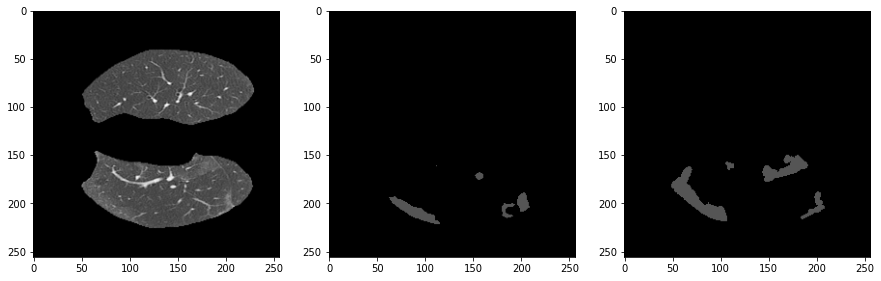

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))
axs[0].imshow(data_test[2][0].squeeze(0), cmap="gray")
axs[1].imshow(progress.predictions[2], cmap="gray", vmax=3)
axs[2].imshow(labels[2], cmap="gray", vmax=3)

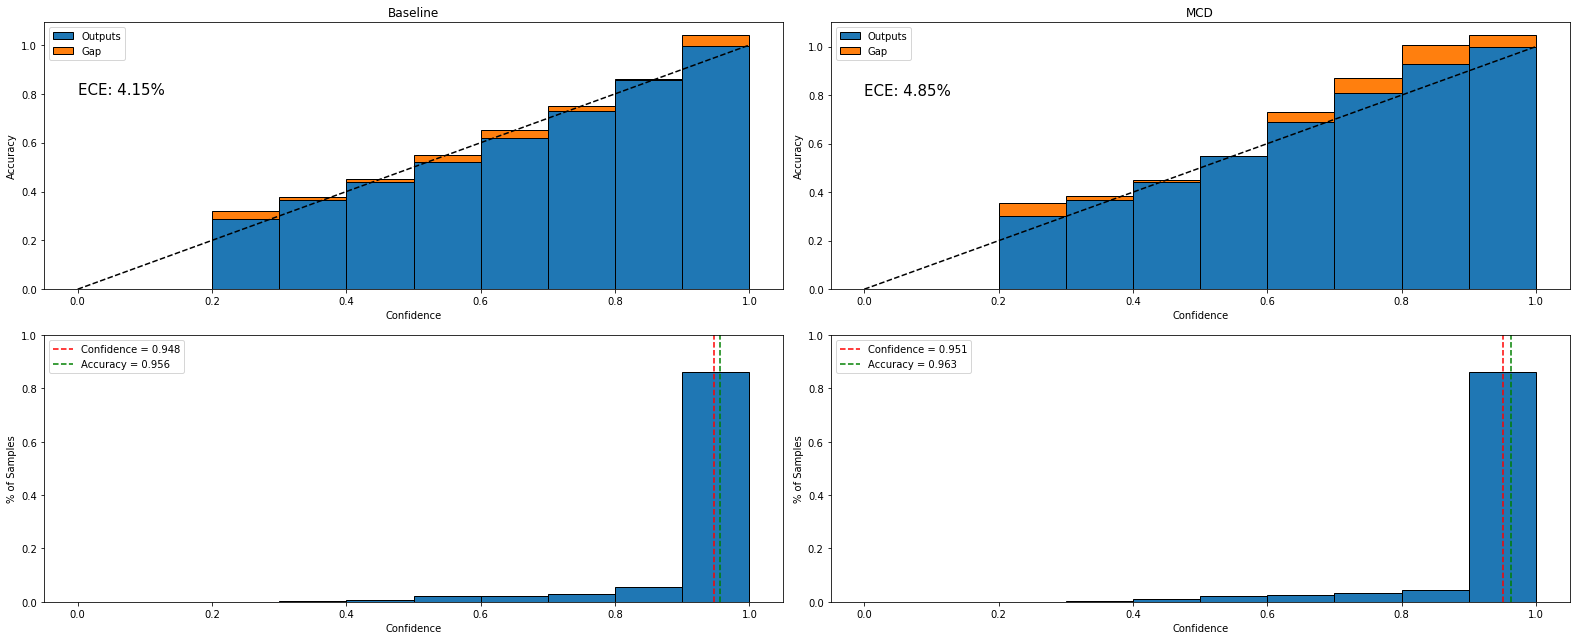

In [7]:
# nll = nn.CrossEntropyLoss()(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# # mc_logits = progress.dropout_logits.mean(axis=0)
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)

# utils.visualisations.samples_removed_vs_acc([
#     ("Max prob", np.argsort(progress.max_probs)),
#     ("Dropout max probs", np.argsort(dropout_max_probs))],
#     progress.labels,
#     progress.predictions,
#     progress.dropout_predictions)

dropout_max_probs = progress_dropout.dropout_outputs.max(axis=1).ravel()

utils.visualisations.calibration_graph([
        ("Baseline", progress.max_probs, np.argsort(progress.max_probs), progress.predictions.ravel()),
        ("MCD", dropout_max_probs, np.argsort(dropout_max_probs), progress_dropout.dropout_outputs.argmax(axis=1).ravel()),
        # ("Temp scaling", progress_scaled.max_probs, np.argsort(progress_scaled.max_probs), progress_scaled.predictions.ravel()),



    ],
    progress.labels,
    )

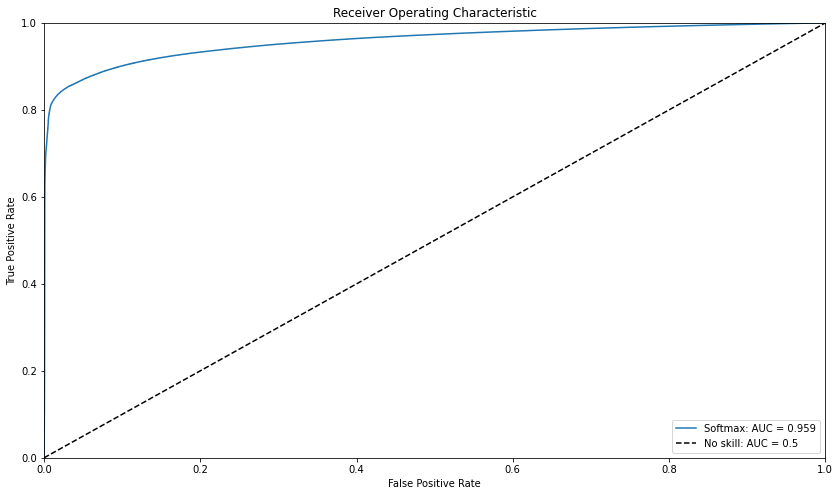

In [13]:
curves = []

correct = progress.predictions.ravel() == progress.labels.ravel()
fpr, tpr, _ = metrics.roc_curve(correct, progress.max_probs)
roc_auc = metrics.auc(fpr, tpr)

prec, recall, _ = metrics.precision_recall_curve(correct, progress.max_probs)
aupr = metrics.auc(recall, prec)
curves.append({
    "fpr": fpr,
    "tpr": tpr,
    "auroc": roc_auc,
    "prec": prec,
    "recall": recall,
    "aupr": aupr,
    "label": "Softmax"
})

# correct = progress.dropout_predictions == progress.labels
# dropout_max_probs = progress.dropout_outputs.max(axis=-1)
# fpr, tpr, _ = metrics.roc_curve(correct, dropout_max_probs)
# roc_auc = metrics.auc(fpr, tpr)

# prec, recall, _ = metrics.precision_recall_curve(correct, dropout_max_probs)
# aupr = metrics.auc(recall, prec)

# curves.append({
#     "fpr": fpr,
#     "tpr": tpr,
#     "auroc": roc_auc,
#     "prec": prec,
#     "recall": recall,
#     "aupr": aupr,
#     "label": "MC Dropout"
# })


plt.figure(figsize=(14, 8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"],
             label=f"{curve['label']}: AUC = {curve['auroc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

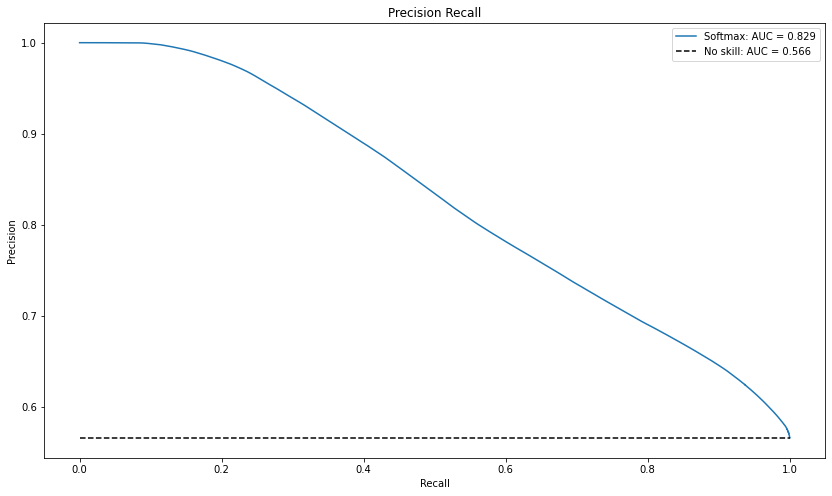

In [10]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14, 8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"],
             label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k",
         linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()